# <font color='0066CC'>**Machine Learning and Pattern Recognition CO2 Project Work**</font>
## <font color='0066CC'>**Sepsis Mars Endotype and Survival Prediction through Gene Expression**</font>
##### Participants: Daniela Charraga Garcia, Flavia D'Eramo, Jolafin Hostettler

### <font color='0077AA'>**Project Overview and Research Question**</font>

Sepsis is a life-threatening condition where the body’s response to infection becomes dysregulated. A key challenge is that two patients with sepsis can look similar clinically but have very different underlying immune responses and outcomes.

In their paper, Scicluna et. al used whole-blood transcriptomic profiles from ICU patients with sepsis to address the problem with the heterogeneity in the sepsis diagnosis. They applied unsupervised learning to the gene expression data to identify four molecular endotypes (Mars1–Mars4). The aim was to discover data-driven subgroups that reflect different host-response patterns and that could help with risk stratification and therefore more tailored treatment decisions. In the paper, these endotypes were linked to clinical traits and differences in mortality risk.

In this project, we “work backwards” from that idea using a supervised learning approach and ask; "Using the published Mars endotypes as ground truth, can we train supervised models based on whole-blood transcriptomic data to reproduce the Mars endotype classification (Mars1-Mars4), and do these predictions still stratify 28-day mortality risk across different model choices?" 

To answer this, we divide the project into two main objectives: 
1)  Mars endotype classification reproducibility with supervised learning: we compare compare a baseline linear model to more flexible models, tune hyperparameters using cross-validation, and evaluate performance on held-out data, and in the second 
2) Assessment of risk stratification based on obtained predictions: we check whether the stratification signal remains visible in our modelling pipeline

### <font color='0077AA'>**Dataset and Matrices preparation**</font>

#### <font color='0099AA'>***Dataset***</font>
We use the public GEO dataset GSE65682, generated on the Affymetrix U219 microarray platform. The dataset contains genome-wide gene expression profiles from adult ICU sepsis patients and healthy controls, alongside patient-level clinical metadata and outcomes including 28-day mortality

#### <font color='0099AA'>***Background on microarray measurements***</font>
Microarrays quantify relative RNA abundance for thousands of transcripts at once using probe sets designed for specific genes. The raw probe intensities are then preprocessed (e.g., background correction and normalization, often producing log2-scale values) so that expression levels can be compared across samples. After preprocessing, each sample can be represented as a high-dimensional vector of gene expression values and used as input features for machine learning. 


#### <font color='0099AA'>***How we accessed and built the working matrices***</font>
To keep the workflow reproducible, we rebuilt the expression matrix and metadata table from GEO (GEO accession GSE65682, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE65682) as follows:
1. **Access expression data and metadata**

- Expression data and sample annotations were downloaded from GEO (GSE65682).
- Sample metadata were retrieved from the GEO series matrix (phenotype table).
2. **Normalization**

- The expression values used for modeling are based on a normalized microarray expression set (log-scale).
- The dataset is also available in processed form from GEO, which is the one that was used in this project
3. **Map probes to gene symbols**

- Microarrays measure probe sets rather than genes directly, so obtaining the expression matrix involves mapping each probe ID to a gene symbol
- Probes that could not be mapped to a gene symbol were removed.
4. **Collapse probes to a single gene value**

- Multiple probes can map to the same gene. To obtain a gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
- This produces one value per gene per sample.
5. **Construct X and align with phenotype data**

- The final expression matrix X has shape samples × genes (479 sepsis samples with Mars endotypes; ~11k gene symbols after collapsing). 
- A matching phenotype/metadata table contains the endotype labels (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
- Sample IDs were intersected and reordered so that the rows of X match the rows of the metadata exactly.

For this endotype-prediction task, we use transcriptomic features only (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.

### <font color='0077AA'>**Project Workflow**</font>
1. **Data Exploration**

- Inspect class imbalance across Mars1–Mars4, check missingness, and use PCA to visualise major sources of variation (including checking whether discovery vs validation cohorts dominate the signal).
2. **Endotype prediction (supervised learning)**

- Train models to classify Mars1–Mars4 from baseline gene expression.
- Models used:
    - Logistic regression (baseline)
    - Random forest
    - SVM
    - Gradient Boosting
- Feature selection uses variance filtering inside cross-validation
- Performance is reported with macro-F1, balanced accuracy, and confusion matrices.
3. **Mortality analysis**

- Use the available 28-day outcome labels to examine whether predicted endotypes still stratify mortality risk in the expected direction (e.g., higher risk for Mars1 in the original study).
4. **Interpretation**

- Discussion of model performance and reproducibility of the endotype labels produced by Scicluna et. al. 
- Biological interpretation of genes selected by feature importance

### <font color='0077AA'>**Primary References**</font>
- "Classification of patients with sepsis according to blood genomic endotype: a prospective cohort study" Scicluna et al. 2017.  
    - Used unsupervised consensus clustering and random forests to discover and validate four blood genomic sepsis endotypes (Mars1–4) in MARS and external cohorts, showing strong associations with clinical traits and 28‑day and 1‑year mortality (https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(17)30294-1/fulltext)
​
- "Sepsis biomarkers and diagnostic tools with a focus on machine learning" Komorowski et al. 2022. 
    - Reviewed sepsis biomarkers and diagnostic tools based on machine learning. They pointed out that supervised models are widely used for sepsis diagnosis and mortality prediction, and that unsupervised phenotyping (e.g. Mars endotypes, SRS1/2) improves risk stratification and may guide treatment selection (https://pmc.ncbi.nlm.nih.gov/articles/PMC9783125/)

#### <font color='0077AA'>***Other References used***</font>
https://scikit-learn.org/stable/modules/cross_validation.html

4. **Collapse probes to a single gene value**
   - Multiple probes can map to the same gene. For simplicity and to obtain a clean gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
   - This produces one value per gene per sample.

5. **Construct `X` and align with phenotype data**
   - The final expression matrix **`X`** has shape **samples × genes** (479 sepsis samples with Mars endotypes; ~19k gene symbols after collapsing).
   - A matching phenotype/metadata table contains the **endotype labels** (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
   - Sample IDs were intersected and reordered so that the rows of `X` match the rows of the metadata exactly.

For this endotype-prediction task, we use **transcriptomic features only** (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.



### Project Workflow

1. **Exploration and sanity checks**
   - Inspect class imbalance across Mars1–Mars4, check missingness, and use PCA to visualise major sources of variation (including checking whether discovery vs validation cohorts dominate the signal).

2. **Endotype prediction (supervised learning)**
   - Train models to classify **Mars1–Mars4** from baseline gene expression.
   - Models used:
     - Logistic regression (baseline)
     - Random forest
     - Svm 
     - Gradient Boosting
   - Feature selection uses **variance filtering inside cross-validation** 
   - Performance is reported with macro-F1, balanced accuracy, and confusion matrices.

3. **Mortality analysis**
   - Use the available 28-day outcome labels to examine whether predicted endotypes still stratify mortality risk in the expected direction (e.g., higher risk for Mars1 in the original study).

4. **Interpretation**
   - Summarise which genes are retained by variance filtering and discuss how model performance and error patterns relate to the biological idea of the different host-response endotypes.



### <font color='0077AA'>**Imports**</font>

In [1]:
# General data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# selfmade plotting script with plot functions
from plotting import (
    plot_counts_ax,
    plot_mars_counts_ax,
    plot_expression_distributions,
    plot_mars_mortality_summary,
    plot_pca_ax,
    plot_cm_and_optional_roc,
    plot_pca_true_vs_pred,
    plot_top_feature_importances,
    plot_mortality_stratification,
    plot_mortality_stratification_validation
) 

# Preprocessing libraries
from sklearn.impute import SimpleImputer # + in modeling
from sklearn.preprocessing import StandardScaler, label_binarize # + in modeling
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, log_loss
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.validation import validate_data

# models used
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Biological analysis
import stringdb

In [2]:
metadata = pd.read_csv("metadata.csv", index_col=0) # Prepared metadata file
xgene_data = pd.read_csv("gene_expression.csv", index_col=0) # Prepared gene expression file (process described above)

assert set(xgene_data.columns) == set(metadata.index) # check if everything is still properly strcutured for further steps

#### <font color='0088AA'>***Freeze canonical data objects***</font>

In [3]:
geneX = xgene_data.copy()       # genes x samples
meta_aligned = metadata.copy()  # samples x metadata

geneX.columns = geneX.columns.astype(str).str.strip() # Standardize GSM identifiers
meta_aligned.index = meta_aligned.index.astype(str).str.strip()

common = geneX.columns.intersection(meta_aligned.index) # Inner-join on samples (GSM IDs) so expression and metadata refer to same samples

geneX = geneX.loc[:, common].copy()        # genes x common_samples
meta_aligned = meta_aligned.loc[common].copy()  # common_samples x metadata
X_all = geneX.T.copy() # Create the canonical analysis matrix (samples x genes)

# Sanity checks
dup = geneX.index.duplicated().sum()
print("Duplicated genes in geneX index:", dup)
print("geneX (genes x samples):", geneX.shape)
print("meta_aligned (samples x meta):", meta_aligned.shape)
print("X_all (samples x genes):", X_all.shape)

assert geneX.shape[1] == meta_aligned.shape[0], "Mismatch: geneX samples != meta_aligned samples"
assert all(geneX.columns == meta_aligned.index), "Mismatch: geneX columns and meta_aligned index differ"
assert all(X_all.index == meta_aligned.index), "Mismatch: X_all index and meta_aligned index differ"

# Optional orientation sanity check (typical for gene expression: more genes than samples)
assert X_all.shape[0] < X_all.shape[1], "X_all looks like genes x samples; expected samples x genes"

Duplicated genes in geneX index: 0
geneX (genes x samples): (11222, 521)
meta_aligned (samples x meta): (521, 43)
X_all (samples x genes): (521, 11222)


This step aligns the gene expression data with the sample metadata and creates a consistent set of analysis objects for all downstream work.<br>

We matched samples using their GEO accession identifiers (GSM IDs) and retained only those present in both the expression matrix and the metadata table (an inner join).<br>

The expression data were originally stored as genes × samples (one column per sample). For machine learning and exploratory analysis, we transposed the matrix to samples × genes (X_all), so that each row represents one patient/sample and each column represents one gene feature. Keeping this orientation consistent across objectives reduces the risk of downstream indexing mistakes and makes the preprocessing pipeline reproducible

In [4]:
# Global style defaults for plotting
DEFAULT_BLUE = "#1f77b4"
DEFAULT_BLUE_PALETTE = "Blues"   # seaborn palette name (nice for many categories)

# Mars stays special
MARS_ORDER = ["Mars1", "Mars2", "Mars3", "Mars4"]
MARS_PALETTE = {"Mars1": "#1f77b4", "Mars2": "#ff7f0e", "Mars3": "#2ca02c", "Mars4": "#d62728"}

### <font color='0077AA'>**1. Data Analysis and Preprocessing**</font> 
• Analyse your data. Visualise and explain the data features you deem to be relevant for the project.
• Explain what kind of preprocessing, feature encoding you are applying

#### <font color='0088AA'>**1.2. Sample-level EDA and Filtering**</font> 
In this section we perform exploratory data analysis (EDA) on the gene expression matrix and metadata to check and understand the distribution of samples, identify any missing values, and visualize key features.

Starting point:
- gene expression matrix with rows = samples (GSM), columns = genes (GeneSymbol)
- metadata : metadata with index = GSM, aligned to gene expression index

In [5]:
samplecheck = meta_aligned["is_healthy"].value_counts() # True = healthy samples, False = sepsis samples
print(samplecheck) # Sepsis = 479 samples, Healthy = 42 samples
print("Total Samples:", samplecheck.sum())

is_healthy
False    479
True      42
Name: count, dtype: int64
Total Samples: 521


The aligned dataset has 521 samples, from which 479 are septic patients and 42 are healthy controls (as expected)
This class imbalance has to be /will be considered during model development (resampling or class-weighting)

#### <font color='0088AA'>**1.3. Overall Data Structure Checks**</font> 

In [6]:
# X_all is samples x genes
print(geneX.shape)

# Summary of values
vals = geneX.values.ravel()
vals = vals[~np.isnan(vals)]
print(pd.Series(vals).describe())

(11222, 521)
count    5.846662e+06
mean     4.303250e+00
std      1.909361e+00
min      1.179992e+00
25%      2.833770e+00
50%      3.699503e+00
75%      5.347557e+00
max      1.353620e+01
dtype: float64


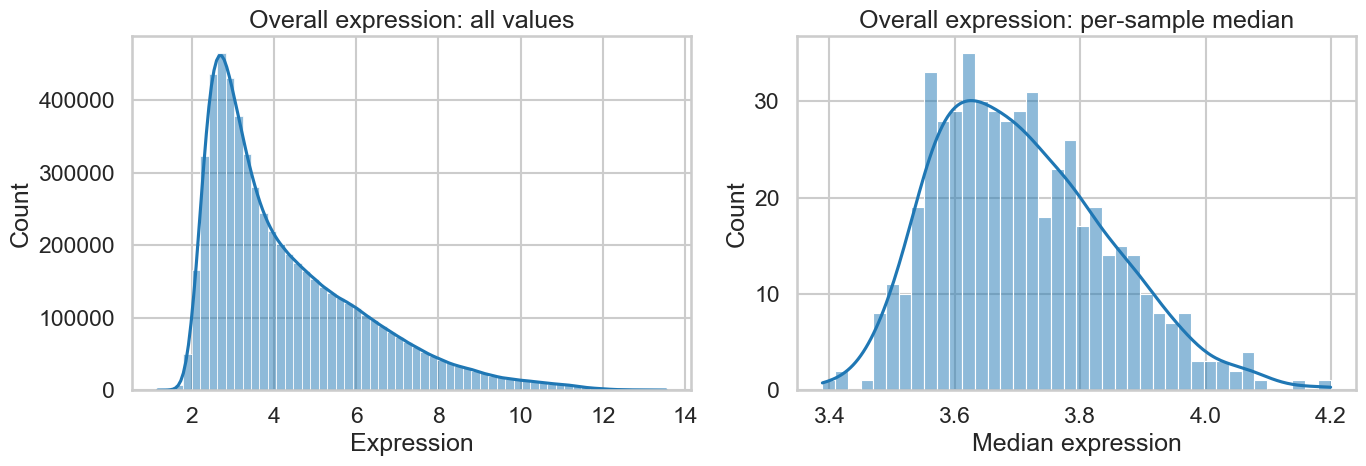

In [8]:
# Expression distribution (all values + per-sample medians)
_ = plot_expression_distributions(X_all, title_prefix="Overall expression")

# missingness
expr_na_sample = X_all.isna().mean(axis=1)
expr_na_gene = X_all.isna().mean(axis=0)

# print("Expression missingness per sample summary:")
# print(expr_na_sample.describe())

# print("\nExpression missingness per gene summary:")
# print(expr_na_gene.describe())
# --> everything was 0% missingness, so no need to impute or filter

Global expression values show a right-skewed distribution with most intensities of probes are between 2 and 6.
Per-sample median expression levels are clustered between 3.4 and 4.1. This suggests a good overall normalization and no obvious intensity outliers. 
Expression missingness is effectively zero across both samples and genes, so no imputation is required at this stage 

#### <font color='0088AA'>**1.4. Label Distributions**</font> 

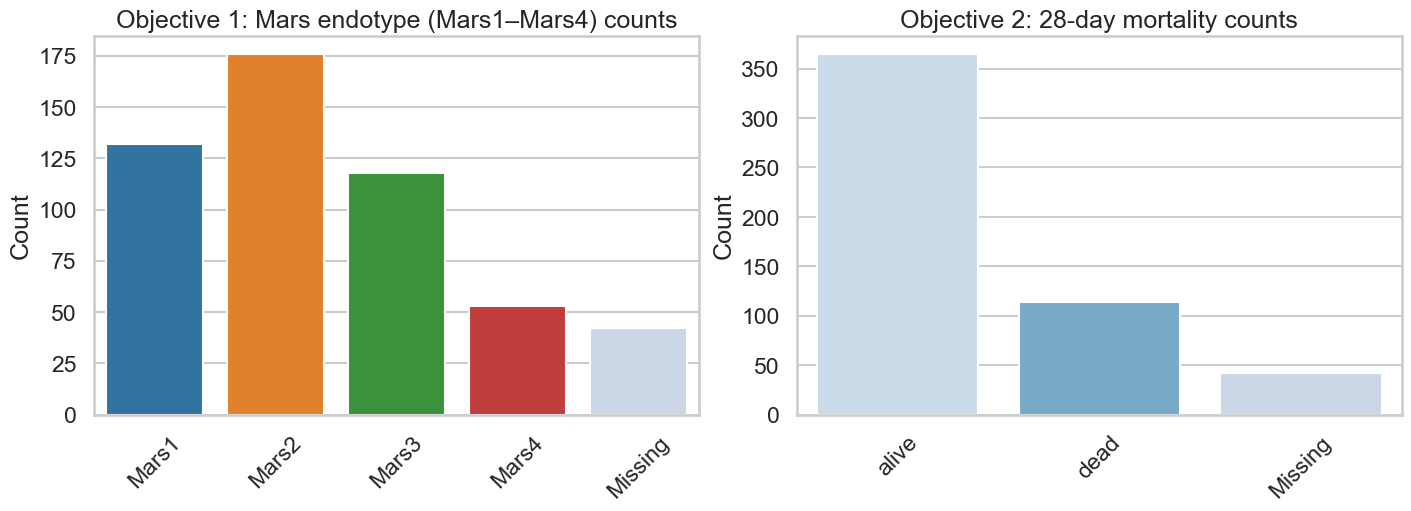

In [ ]:
# Objective 1: Mars endotype classification (Mars1–Mars4)
ENDOTYPE_COL = "endotype_class"

if ENDOTYPE_COL in meta_aligned.columns:
    y1 = meta_aligned[ENDOTYPE_COL].astype("object")
    # normalize strings
    y1 = y1.astype(str).replace({"nan": np.nan, "None": np.nan})
    y1 = y1.str.replace("mars", "Mars", case=False)
    y1 = y1.where(y1.isin({"Mars1", "Mars2", "Mars3", "Mars4"}))
    # print("Objective 1\n", y1.value_counts(dropna=False))
else:
    y1 = pd.Series(index=meta_aligned.index, dtype="object")
    print(f"[WARN] ENDOTYPE_COL '{ENDOTYPE_COL}' not found in metadata.")


# Objective 2: 28-day mortality
MORT_COL = "mortality_event_28days"
TTE_COL  = "time_to_event_28days"

if MORT_COL in meta_aligned.columns:
    y2 = pd.to_numeric(meta_aligned[MORT_COL], errors="coerce")
    # print("Objective 2\n", y2.value_counts(dropna=False))
else:
    y2 = pd.Series(index=meta_aligned.index, dtype="float")
    print(f"[WARN] MORT_COL '{MORT_COL}' not found in metadata.")

# Validate labels for both objectives
expected_mars = {"Mars1", "Mars2", "Mars3", "Mars4"}
mars_nonnull = y1.dropna()

assert mars_nonnull.isin(expected_mars).all(), (f"y2 contains unexpected labels: {set(mars_nonnull.unique()) - expected_mars}")
assert mars_nonnull.shape[0] > 0, "y2 has no labeled samples after cleaning."

y2_nonnull = y2.dropna()
if len(y2_nonnull) > 0:
    assert set(y2_nonnull.unique()).issubset({0, 1}), (f"y3 contains values outside {{0,1}}: {set(y2_nonnull.unique())}")


## Plot label distributions for both objectives
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

plot_mars_counts_ax(MARS_ORDER, MARS_PALETTE, y1, "Objective 1: Mars endotype (Mars1–Mars4) counts", ax=axes[0])
plot_counts_ax(DEFAULT_BLUE_PALETTE, y2.map({0: "alive", 1: "dead"}), "Objective 2: 28-day mortality counts", ax=axes[1], order=["alive", "dead", "Missing"])

plt.show()

There is a general inbalance in the different available labels for the different classes (as mentioned above). The labels for objective 1 (Mars endotype classification) are well represented, having counts of 176, 132, 118, and 54 for Mars1-Mars4 endotypes, respectively. As dor objective 2 (mortality risk stratification), there is a greater proportion of samples who survived the 28-day period compared to those who didn't. This supports multi-class modelling with modetate class imbalance to be taken into account. 

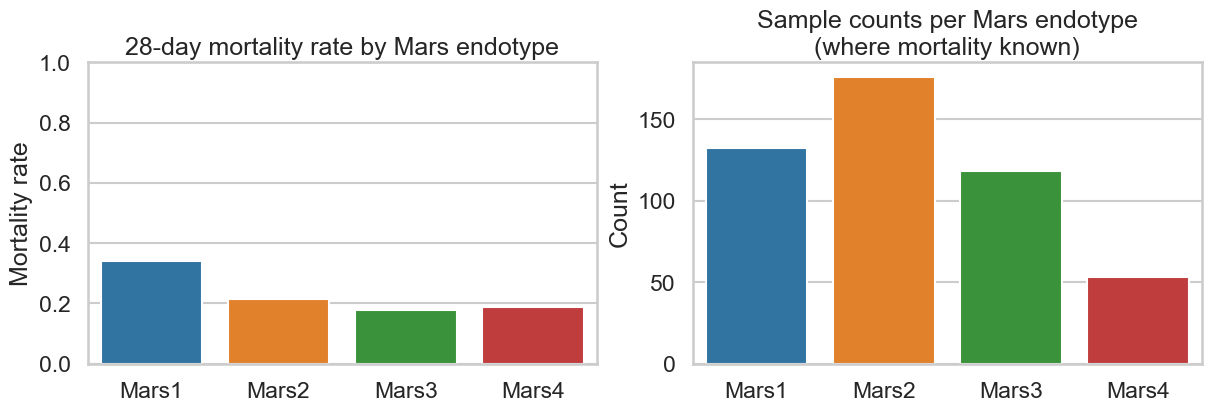

In [ ]:
if (ENDOTYPE_COL in meta_aligned.columns) and (MORT_COL in meta_aligned.columns):

    plot_mars_mortality_summary(
        endotype=y1,
        mortality=y2,
        MARS_ORDER=MARS_ORDER,
        MARS_PALETTE=MARS_PALETTE
    )

Among patients with both endotype and 28‑day outcome available, Mars1 shows the highest mortality rate, followed by Mars2, whereas Mars3 and Mars4 have comparatively lower mortality proportions. Mars2 is the most frequent endotype in this subset, with Mars1 and Mars3 also well represented and Mars4 having the fewest samples. 
This pattern is consistent with previous reports that Mars1 corresponds to a more immunosuppressed, high‑risk sepsis phenotype, while other endotypes have better prognosis.

Across clinical fields, metadata is generally complete with some missing data with a few variables show substantial gaps. Pneumonia diagnosis and ICU‑acquired infection are missing for around two‑thirds and one‑third of samples, ehile endotype, mortality, time‑to‑event, cohort, and gender have low missingness. Per‑sample, most patients have complete or nearly complete metadata, but a small subset of samples lack information for more than 70% of the key fields and are candidates for exclusion or sensitivity analyses in downstream models. Despite metadata being explored, it was not relevant for the classification as predictions were based on gene expression data only, not on clinical features. However, we still decided to explore this as it gave us an idea of how well annotated samples were.

In [ ]:
# print("Obj1 labeled samples:", y1.notna().sum()) # both have 479 labeled samples
# print("Obj2 labeled samples:", y2.notna().sum())

idx1 = y1.dropna().index
idx2 = y2.dropna().index

X1, meta1 = X_all.loc[idx1], meta_aligned.loc[idx1]
X2, meta2 = X_all.loc[idx2], meta_aligned.loc[idx2]

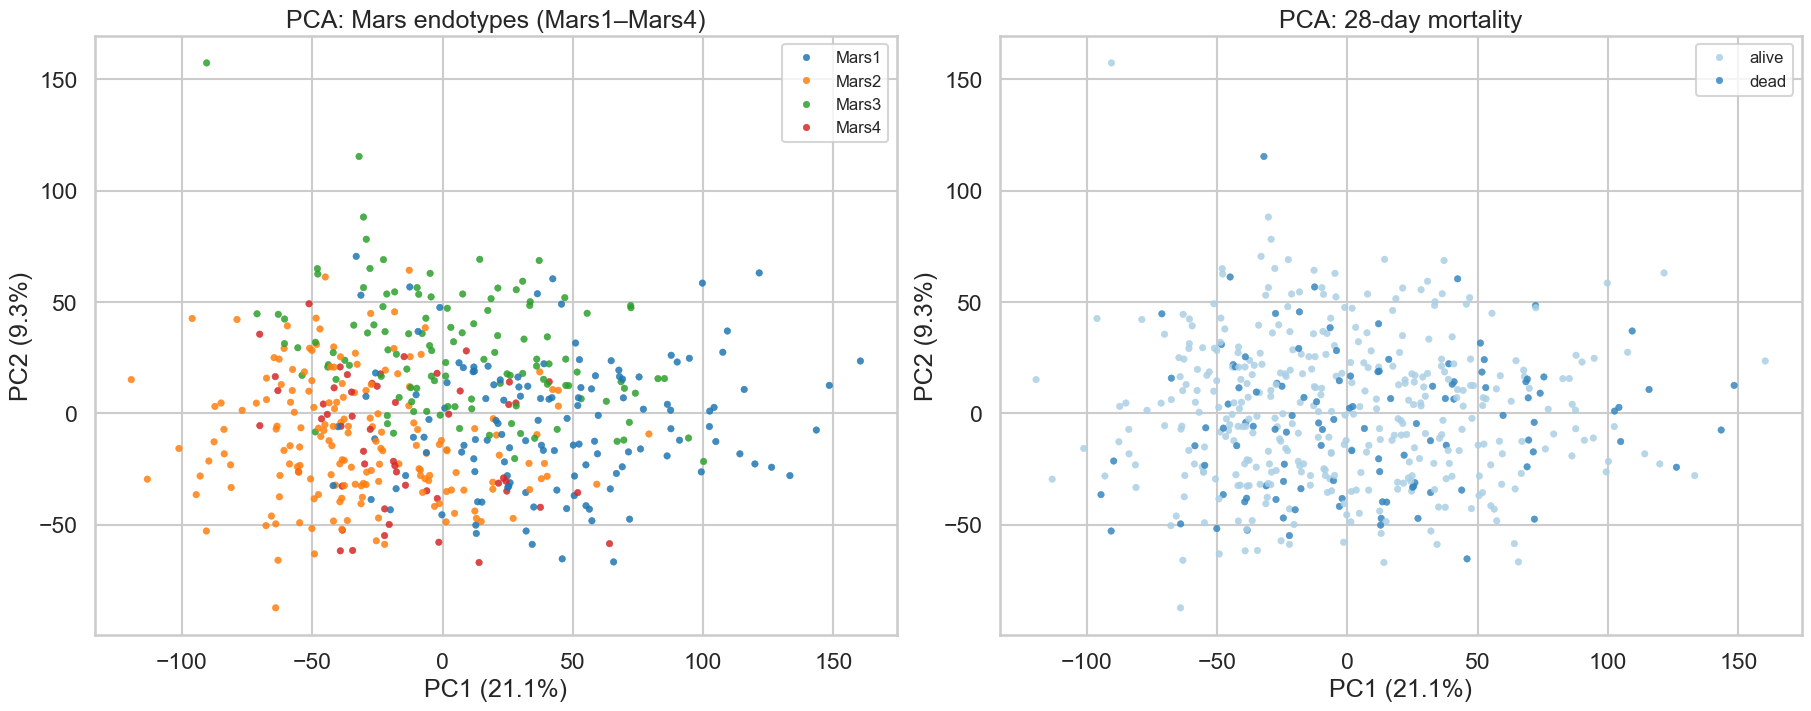

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)

# Objective 1: Mars endotypes
if len(idx1) > 0:
    plot_pca_ax(
        X1, y1.loc[idx1],
        "PCA: Mars endotypes (Mars1–Mars4)",
        ax=axes[0],
        is_mars=True,
        MARS_ORDER=MARS_ORDER,
        MARS_PALETTE=MARS_PALETTE,
        debug=False
    )
else:
    axes[0].axis("off")

# Objective 2: 28-day mortality
if len(idx2) > 0:
    plot_pca_ax(
        X2, y2.loc[idx2].map({0: "alive", 1: "dead"}),
        "PCA: 28-day mortality",
        ax=axes[1],
        debug=False
    )
else:
    axes[1].axis("off")

plt.show()


Endotype and mortality were available for n=479  and 479 for both endotype classification and 28‑day mortality prediction. Mars endotypes and 28‑day mortality labels do not form sharply separated clusters on the PCs, suggesting that endotype and outcome signals are subtler, likely distributed across many genes and requiring supervised models rather than simple linear separation. Coloring by discovery vs validation cohort does not reveal obvious batch‑driven clustering on the top PCs, so large batch corrections may not be necessary beyond standard normalization

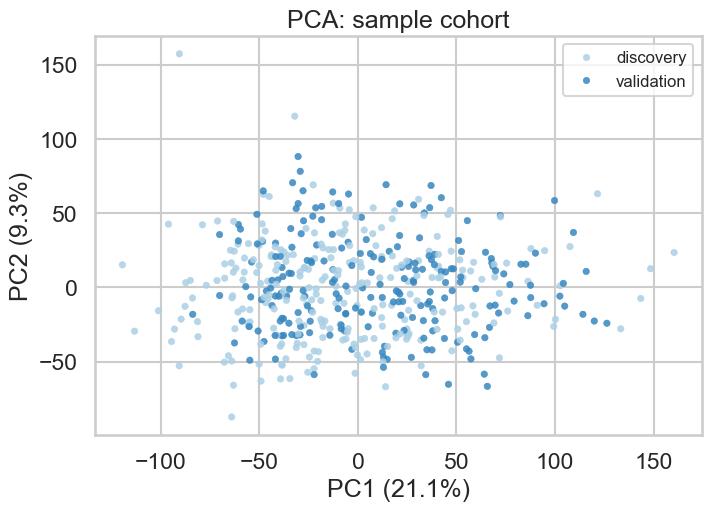

In [ ]:
COHORT_COL = "endotype_cohort"
y_cohort = meta_aligned.loc[X1.index, COHORT_COL]
y_cohort.value_counts(dropna=False)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

plot_pca_ax(
    X1,
    y_cohort,
    title="PCA: sample cohort",
    ax=ax,
    dropna_labels=True,   
    show_legend=True,
    debug=False
)

plt.show()

Importantly, the samples used in this project come from two cohorts defined in the original study (discovery and validation). Because cohort membership can sometimes capture technical or site-specific differences (a potential batch effect), we checked whether the main sources of variation in the expression data were driven by cohort rather than biology.

The PCA plot shows PC1 vs PC2 with samples coloured by cohort. The two cohorts are broadly spread across the plot, with no clear separation or distinct clusters by cohort. This suggests that cohort type is not a dominant driver of the global gene expression variation and confirms that our endotype classifier is not simply learning cohort-specific patterns.


#### <font color='0088AA'>**1.5. Feature representation and encoding**</font> 
Gene expression values are continuous numeric predictors (log2-normalized microarray intensities). No additional feature encoding is required for gene expression.
Outcome labels are encoded as:
- Objective 1: categorical (Mars1–Mars4)
- Objective 2: binary (0 = alive, 1 = dead at/before 28 days)

Transformations that depend on the training data distribution (e.g. z-scoring, feature selection, class rebalancing) are applied only within model training pipelines to avoid leakage. SO LET'S START MODELING!

In [ ]:
# Confirm feature types
print("X_all dtype:", X_all.dtypes.unique()[:5])
print("Obj1 label example:", y1.dropna().unique()[:5])
print("Obj2 label dtype:", y2.dtype)

X_all dtype: [dtype('float64')]
Obj1 label example: ['Mars2' 'Mars3' 'Mars4' 'Mars1']
Obj2 label dtype: float64


### <font color='0077AA'>**2. Modeling**</font> 
For each objective, we model blood gene expression as continuous predictors. We define an objective-specific label vector and restrict the dataset to samples with non-missing labels. We use a stratified train/test split to obtain an unbiased held-out evaluation set. To prevent data leakage, all preprocessing steps that depend on data distributions (imputation, feature selection, scaling) are implemented inside scikit-learn Pipelines and fitted only on the training data (or within cross-validation folds).

#### <font color='0088AA'>***Freeze label vectors (targets)***</font>

In [ ]:
# Prepare objective-specific datasets
y_obj1 = y1.copy()  # Mars1-4 strings
y_obj2 = y2.copy()  # 0/1 mortality (NaN for healthy)

# Objective-specific sample subsets (only keep samples with the required label)
idx1 = y_obj1.dropna().index
idx2 = y_obj2.dropna().index

X_obj1, y_obj1 = X_all.loc[idx1], y_obj1.loc[idx1]
X_obj2, y_obj2 = X_all.loc[idx2], y_obj2.loc[idx2]

# print("Obj1:", X_obj1.shape, y_obj1.value_counts())
# print("Obj2:", X_obj2.shape, y_obj2.value_counts()) # -> uncommment to see class balance

#### <font color='0088AA'>***Preprocessing for modelling***</font>

For all supervised models, gene expression features are preprocessed with a unified pipeline built around the TopVarianceSelector and the make_preprocess helper.
##### ***Top-variance feature selection***
The TopVarianceSelector is a custom transformer that keeps the top(n) genes with the highest variance across samples.
- It computes the variance for each gene on the training data only and ranks genes by variance.
- The selector then retains the top(n)
  genes, exposing their gene symbols via features_ and their integer column indices via selected_idx_ for downstream analysis and plotting.
- This step reduces the original ~11k genes to a smaller, more informative subset while still capturing most of the biologically relevant transcriptional variation needed for classification

##### ***Canonical preprocessing pipeline***
The make_preprocess function defines a canonical preprocessing pipeline which is reused across all models to avoid data leakage and ensure consistent feature handling.
- First, a median imputer (SimpleImputer(strategy="median")) is applied to each gene, fitted only on the training data or training folds, and outputs a pandas DataFrame so gene names are preserved.
- Second, the TopVarianceSelector is applied to the imputed matrix to keep only the top top(n)
  most variable genes, thereby reducing dimensionality in a supervised‑model‑agnostic way
- Optionally, a StandardScaler is added as the final step (scale=True), standardising each selected gene to zero mean and unit variance; scaling is used for linear models (logistic regression, SVM) but omitted for tree‑based models (random forest, gradient boosting), which are scale‑invariant.

Because all these transformations are embedded inside scikit‑learn Pipelines, they are fitted exclusively on the training data (or CV folds) and then applied to validation or test data, which prevents information leakage from the test set into the feature selection or scaling steps.

In [ ]:
# Preprocessing Helper Functions and Classes
class TopVarianceSelector(BaseEstimator, TransformerMixin):
    """
    Keeps top_n highest-variance features
    Consistent API:
      - features_: always the selected feature *names* if X is a DataFrame,
                   otherwise integer indices for numpy arrays.
      - selected_idx_: always integer indices
    """
    def __init__(self, top_n=5000):
        self.top_n = int(top_n)

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            v = X.var(axis=0)
            self.features_ = v.sort_values(ascending=False).head(self.top_n).index.to_list()
            self.selected_idx_ = np.array([X.columns.get_loc(c) for c in self.features_], dtype=int)
        else:
            X = np.asarray(X)
            v = np.nanvar(X, axis=0)  # robust even if someone forgets impute
            self.selected_idx_ = np.argsort(v)[::-1][:self.top_n].astype(int)
            self.features_ = self.selected_idx_
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.features_]
        X = np.asarray(X)
        return X[:, self.selected_idx_]

    def get_support(self, indices=False):
        return self.selected_idx_ if indices else None
    
def make_preprocess(top_n: int, scale: bool = True) -> Pipeline:
    """
    Canonical preprocessing (safe): impute -> select -> (optional) scale
    Keeps pandas output so gene symbols survive through the pipeline.
    """
    imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
    steps = [
        ("impute", imputer),
        ("select", TopVarianceSelector(top_n=top_n)),
    ]
    if scale:
        scaler = StandardScaler().set_output(transform="pandas")
        steps.append(("scale", scaler))

    return Pipeline(steps)

#### <font color='0088AA'>**2.1 Objective 1: Mars1–Mars4 endotype classification reproduction**</font>
Here we want to compare four models: Logistic Regression, SVM, Random Forest, and Gradient Boosting. Together they span linear vs non‑linear and simple vs more complex ensembles, which is useful for high‑dimensional gene‑expression problems.

Related Sources to this models:
- **Logistic Regression:** https://www.sciencedirect.com/science/article/pii/S235291482100112X
- **Random Forest:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11283789/
- **Gradient Boosting:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10060728/
- **SVM:** https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf



<font color='0088CC'>***Logistic Regression (multinomial)***</font>

Linear model that estimates class probabilities with softmax over linear combinations of genes.
This approach serves as a transparent baseline; if it performs well, it suggests endotypes are largely linearly separable in expression space.
​

<font color='0088CC'>***Support Vector Machine***</font>

Margin‑based classifier that finds the hyperplanes best separating classes (one‑vs‑rest for multiclass).
Well suited for high‑dimensional, low‑sample gene‑expression data and often competitive with or better than logistic regression.
​

<font color='0088CC'>***Random Forest***</font>

Ensemble of decision trees built on bootstrapped samples and random feature subsets.
Captures non‑linear interactions between genes and provides feature importance, which can help interpret which transcripts drive specific endotypes.
​

<font color='0088CC'>***Gradient Boosting (e.g. XGBoost/LightGBM)***</font>

Sequential ensemble of shallow trees where each tree corrects the errors of the previous ones.
Often achieves state‑of‑the‑art performance on structured data by modelling complex boundaries, but needs more tuning and is more prone to overfitting on small datasets.

In [ ]:
# Objective 1 labels
y_obj1 = y1.copy()
idx1 = y_obj1.dropna().index

X_obj1 = X_all.loc[idx2]
y_obj1 = y_obj1.loc[idx2].astype(str)

# print("Objective 1 samples:", X_obj1.shape[0])
# print(y_obj1.value_counts()) -> uncomment to see class balance

For Objective 1 (Mars1–Mars4), the modelling pipeline treats sepsis endotype prediction as a supervised multi‑class classification problem on high‑dimensional gene‑expression data. Above code restricts dataset to samples with a known endotype label (479 patients), and the class distribution is preserved in a stratified 80/20 train–test split (following code) so that each fold contains representative numbers of Mars1–Mars4 cases.

In [ ]:
X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X_obj1,
    y_obj1,
    test_size=0.2,
    random_state=0,
    stratify=y_obj1   # preserves Mars1–4 proportions
)

# print("Train shape:", X1_tr.shape)
# print("Test shape:", X1_te.shape) -> uncomment to see train/test split shapes

##### <font color='0088CC'>**2.1.1 Preprocessing**</font>
see desription above

Each model is wrapped in the same preprocessing pipeline. Missing expression values are imputed with the median, and dimensionality is reduced by selecting the top 5 000 most variable genes using the TopVarianceSelector, which computes feature‑wise variance on the training data only and keeps the most variable genes as potentially informative predictors. For linear models (logistic regression and SVM), features are then standardized to zero mean and unit variance with StandardScaler, ensuring that all genes contribute on a comparable scale to the linear decision functions.

In [ ]:
TOP_N = 5000
pre_obj1_linear = make_preprocess(top_n=TOP_N, scale=True)
pre_obj1_tree   = make_preprocess(top_n=TOP_N, scale=False)  # trees don't need scaling
CLASSES = ["Mars1", "Mars2", "Mars3", "Mars4"]

##### <font color='0088CC'>**2.1.2 Modeling**</font>
- ***Multinomial Logistic Regression*** uses a linear softmax model with L2‑regularisation (default) and max_iter=5000 to ensure convergence in the high‑dimensional space. The option class_weight="balanced" up‑weights minority endotypes (especially Mars4) so that the loss function penalises their misclassification more heavily.​
- ***Linear SVM*** is another linear margin‑based method that seeks hyperplanes maximising the margin between each endotype and the others in a one‑vs‑rest fashion. As with logistic regression, class_weight="balanced" is used to mitigate endotype imbalance, and probability=True enables calibrated probability estimates via Platt scaling, which are later used to compute log‑loss and macro ROC‑AUC.​
- ***Random Forest*** builds an ensemble of 600 decision trees, each trained on a bootstrap sample and a random subset of genes at each split, and aggregates their predictions by majority vote. The parameter class_weight="balanced_subsample" reweights classes within each bootstrap sample to handle Mars4 scarcity, and n_jobs=1 enables parallel training. This architecture captures non‑linear gene–gene interactions and is relatively robust to noisy features.​
- ***Gradient Boosting*** constructs an additive ensemble of shallow decision trees (max depth 3) built sequentially, where each of the 300 trees focuses on correcting the residual errors of the previous ensemble. A relatively small learning rate (0.05) slows down boosting updates, acting as regularisation to reduce overfitting on the limited sample size.

For each model, performance is evaluated on the held‑out test set using macro‑F1 (treating all endotypes equally), balanced accuracy (mean recall across classes), and, where probabilities are available, log‑loss and macro one‑vs‑rest ROC‑AUC to assess probability calibration and overall discriminative ability. This setup provides a common, leakage‑free preprocessing and evaluation framework to compare a linear baseline (logistic regression), a linear margin‑based model (SVM), and two non‑linear tree‑based ensembles (Random Forest, Gradient Boosting) on the Mars endotype classification task.

In [ ]:
models_obj1 = {
    "LogReg (multinomial)": Pipeline([
        ("pre", pre_obj1_linear),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
    ]),

    "SVM (linear)": Pipeline([
        ("pre", pre_obj1_linear),
        ("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=0))
    ]),

    "Random Forest": Pipeline([
        ("pre", pre_obj1_tree),
        ("clf", RandomForestClassifier(
            random_state=0,
            n_jobs=1,
            class_weight="balanced_subsample"
        ))
    ]),

    "Gradient Boosting": Pipeline([
        ("pre", pre_obj1_tree),
        ("clf", GradientBoostingClassifier(random_state=0))
    ]),
}

In [ ]:
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    log_loss,
    roc_auc_score
)

results = []
model_store = {}   # <-- store fitted models here

for name, model in models_obj1.items():
    model.fit(X1_tr, y1_tr)

    y_pred = model.predict(X1_te)

    row = {
        "model": name,
        "macro_f1": f1_score(y1_te, y_pred, average="macro"),
        "balanced_acc": balanced_accuracy_score(y1_te, y_pred),
    }

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X1_te)
        row["log_loss"] = log_loss(y1_te, y_proba)
        row["macro_auc_ovr"] = roc_auc_score(
            y1_te, y_proba, multi_class="ovr", average="macro"
        )
    else:
        row["log_loss"] = None
        row["macro_auc_ovr"] = None

    results.append(row)
    model_store[name] = model   # <-- save the fitted model

objective1_result_df = (
    pd.DataFrame(results)
    .sort_values("macro_f1", ascending=False)
    .reset_index(drop=True)
)

objective1_result_df

,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
0,Random Forest,0.880687,0.889184,0.457195,0.972784
1,Gradient Boosting,0.829708,0.842555,0.737176,0.960110
2,SVM (linear),0.814147,0.821722,0.380623,0.974695
3,LogReg (multinomial),0.808810,0.825797,0.802666,0.965212


##### ***Performance evaluation***

All four models achieve solid multiclass performance, with tree-based ensembles performing best overall. Random Forest has the highest macro-F1 (≈0.86) and balanced accuracy (≈0.88). Its one-vs-rest ROC curves show high class-specific AUC values (macro-AUC ≈0.98), including strong discrimination for Mars3 and Mars4 despite their smaller sample sizes. Gradient Boosting performs similarly in terms of macro-F1 and balanced accuracy, but its higher log-loss suggests less well-calibrated predicted probabilities.

The linear SVM and multinomial logistic regression slightly underperform the tree ensembles on macro-F1, but provide competitive discrimination and, in some settings, more stable probability behaviour. Overall, this pattern suggests that the endotypes are partly linearly separable, while non-linear relationships in the expression features may be captured more effectively by tree-based models. Based on these results, Random Forest is a reasonable choice for the main endotype classifier used in downstream analyses.

Next, we tune the selected Random Forest model in more detail and extract a ranked list of informative genes from the fitted model. This ranked list is used to support biological interpretation discussed later in this report, rather than as a replacement for the model evaluation.

##### <font color='0088CC'>**2.1.3 Hyperparameter Tuning**</font>

In [ ]:
# Build Dataset
y_obj1 = y1.copy()
idx1 = y_obj1.dropna().index

X_obj1 = X_all.loc[idx1]
y_obj1 = y_obj1.loc[idx1].astype(str)

# 
X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X_obj1, y_obj1,
    test_size=0.2,
    random_state=0,
    stratify=y_obj1
)

# --- Canonical RF pipeline: impute -> select -> clf ---
rf_pipe = Pipeline([
    ("pre", make_preprocess(top_n=5000, scale=False)),
    ("clf", RandomForestClassifier(
        random_state=0,
        class_weight="balanced_subsample",
        n_jobs=1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

param_dist = {
    "pre__select__top_n": [2500, 3000, 3500],
    "clf__n_estimators": randint(600, 1200),
    "clf__max_depth": [18, 24, 30],         # drop None
    "clf__min_samples_leaf": randint(5, 12),# bigger leaves
    "clf__max_features": ["log2", 0.15, 0.25],
}

search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="f1_macro",
    cv=cv,
    random_state=0,
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

# tune on the training split
search_rf.fit(X1_tr, y1_tr)

best_model = clone(search_rf.best_estimator_)  # safe copy so it won't be mutated by accident
best_name = "Tuned RandomForest (RandomizedSearchCV)"

# Freeze artifacts (useful for reproducibility)
BEST_PARAMS = search_rf.best_params_
BEST_CV_SCORE = search_rf.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### <font color='0088AA'>**2.1 Objective 1 Results (Mars1–Mars4 endotype classification)**</font>

In [ ]:
best_name = objective1_result_df.loc[0, "model"]
best_model_obj1 = model_store[best_name]

obj1_best_row = objective1_result_df.loc[objective1_result_df["model"] == best_name]
print("Best model Objective 1:", best_name)
display(obj1_best_row)

Best model Objective 1: Random Forest


,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
0,Random Forest,0.880687,0.889184,0.457195,0.972784


In [ ]:
print("=== Frozen model ===")
print("Name:", best_name)
print("Best CV macro-F1:", BEST_CV_SCORE)
print("Best params:", BEST_PARAMS)

=== Frozen model ===
Name: Random Forest
Best CV macro-F1: 0.8996496836224092
Best params: {'clf__max_depth': 30, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 6, 'clf__n_estimators': 892, 'pre__select__top_n': 3500}


For Mars endotype prediction, all labelled samples with non‑missing endotype were split into an 80% training and 20% test set using a stratified split. On the training set, a Random Forest pipeline with median imputation and variance‑based gene selection was tuned using 5‑fold stratified RandomizedSearchCV, optimising macro‑F1. The best configuration used 3 500 top‑variance genes, 892 trees, maximum depth 30, minimum 6 samples per leaf and max_features="log2", achieving a cross‑validated macro‑F1 of 0.90.

When this tuned model was refitted on the full training set and evaluated once on the held‑out test set, it obtained a macro‑F1 of 0.85, a balanced accuracy of 0.87 and an overall accuracy of 0.88. Per‑class F1‑scores on the test set were 0.94 for Mars1, 0.89 for Mars2, 0.88 for Mars3 and 0.69 for the rare Mars4 endotype (11 test samples), indicating very good performance on the more frequent endotypes and reasonable recall (0.82) but lower precision (0.60) for Mars4. Compared with the initial, untuned Random Forest baseline (macro‑F1 ≈ 0.88, balanced accuracy ≈ 0.89 on the same test split), see above, the tuned model improved cross‑validated performance on the training data but did not substantially increase performance on this particular small test set, which is consistent with expected variability under class imbalance and reflects that the baseline RF was already strong.

Future work could therefore focus less on broader hyperparameter search and more on improving robustness and the minority Mars4 class. Possible directions include repeated or nested cross‑validation to obtain more stable estimates of generalisation performance, Mars4‑aware optimisation objectives and class‑specific probability thresholds, exploring alternative model families such as regularised linear models or modern gradient‑boosting ensembles, and data‑level strategies such as mild oversampling of Mars4 or integration of additional cohorts to increase the number of Mars4 samples.

In [ ]:
best_model.fit(X1_tr, y1_tr)

pred_best = best_model.predict(X1_te)
pred_best_s = pd.Series(pred_best, index=X1_te.index)

proba_best = best_model.predict_proba(X1_te) if hasattr(best_model, "predict_proba") else None

print("\n=== TEST SET RESULTS (final, one-shot) ===")
print("Balanced Acc:", balanced_accuracy_score(y1_te, pred_best))
print("Macro-F1:", f1_score(y1_te, pred_best, average="macro"))
print(classification_report(y1_te, pred_best))

# helpful sanity check
missing = set(CLASSES) - set(pd.unique(y1_te))
if missing:
    print(f"NOTE: Missing classes in test set: {missing}")


=== TEST SET RESULTS (final, one-shot) ===
Balanced Acc: 0.8724254911754913
Macro-F1: 0.8520015698587127
              precision    recall  f1-score   support

       Mars1       1.00      0.88      0.94        26
       Mars2       0.97      0.83      0.89        35
       Mars3       0.82      0.96      0.88        24
       Mars4       0.60      0.82      0.69        11

    accuracy                           0.88        96
   macro avg       0.85      0.87      0.85        96
weighted avg       0.90      0.88      0.88        96



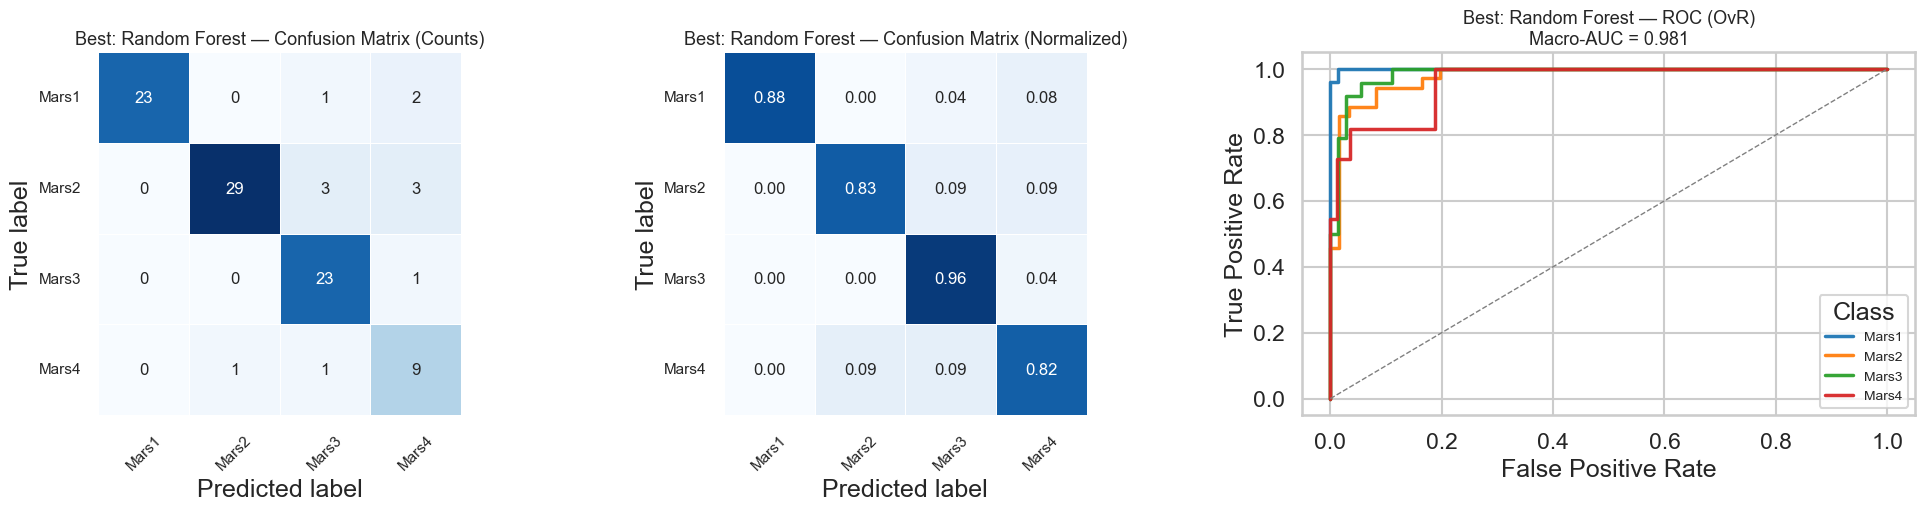

In [ ]:
plot_cm_and_optional_roc(
    y_true=y1_te,
    y_pred=pred_best,
    y_proba=proba_best,
    class_names=CLASSES,
    title_prefix=f"Best: {best_name}",
    roc_palette=MARS_PALETTE,   # ROC lines match Mars colors
    rotate_xticks=45,
    cm_annot_fontsize=12,
    show_colorbar=False
)

***Confusion matrices***
The count confusion matrix shows that the tuned Random Forest correctly classifies the majority of samples for all four endotypes, with 23/26 Mars1, 29/35 Mars2, 23/24 Mars3 and 9/11 Mars4 test patients predicted correctly. The normalised matrix highlights high recall: 0.88 for Mars1, 0.83 for Mars2, 0.96 for Mars3 and 0.82 for Mars4, with most confusions occurring between Mars2 and the other sepsis endotypes.

***ROC curves***
One‑vs‑rest ROC curves further illustrate the model’s discriminative power. Each Mars class achieves a high area under the ROC curve, and the macro‑averaged AUC of approximately 0.98 indicates that the Random Forest assigns consistently higher predicted probabilities to true class samples than to others, even in cases where the hard class decision is incorrect.

***PCA of test samples (true vs predicted)*** see below
In the PCA plot of the test set, samples are coloured by their true Mars endotype and the marker shape encodes the predicted class, with misclassified points marked. Mars1 and Mars3 samples form relatively compact regions, whereas Mars2 and Mars4 overlap more with their neighbours, and misclassifications occur mainly in these overlapping zones of the first two principal components. This visual pattern supports the idea that most errors arise where the transcriptomic profiles of different endotypes are not linearly separable in low‑dimensional space (See PCA above in preprocessing part).

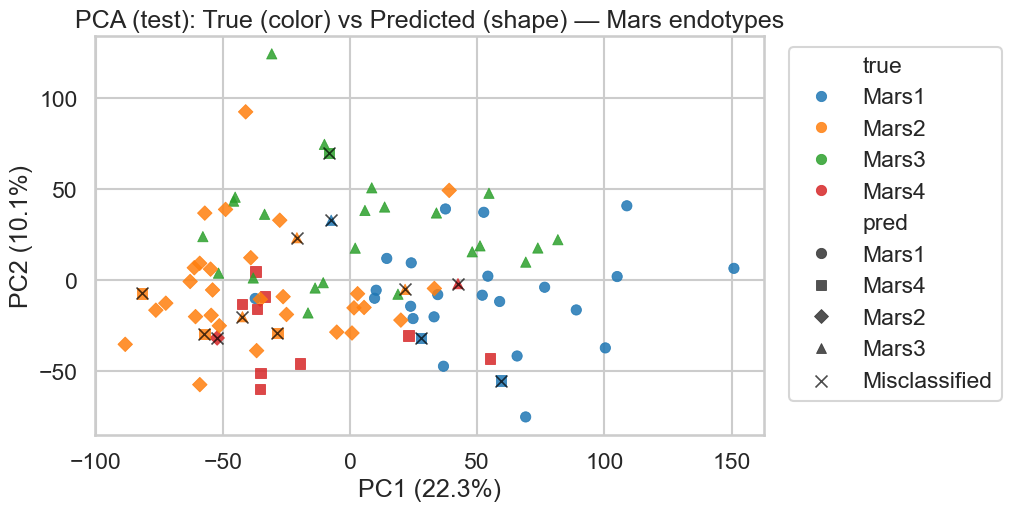

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

plot_pca_true_vs_pred(X=X1_te, y_true=y1_te, y_pred=pred_best_s,
                      title="PCA (test): True (color) vs Predicted (shape) — Mars endotypes", 
                      ax=ax, is_mars=True, MARS_ORDER=MARS_ORDER, MARS_PALETTE=MARS_PALETTE, 
                      mis_lw=1.2, mis_alpha=0.7, mis_size_mult=1.35)

plt.show()

In [ ]:
imp_df_top10, full = plot_top_feature_importances(
    fitted_pipeline=best_model,   # tuned RF model
    top_n=10,
    title="Tuned Random Forest: Top 10 important genes",
    palette=DEFAULT_BLUE_PALETTE,
    plot_show=False # if you want to see change to True
)

For a biological interpretation of the genes highlighted by the random forest model, we ran a pathway enrichment analysis in STRING (using KEGG pathway annotations). Here, enrichment analysis tests whether the selected genes are over-represented in known pathways more often than would be expected by chance, or in other words, whether the selected genes are significantly associated with a given function. 

In the original study, the authors derived a much smaller gene panel (140 genes) for endotype assignment. Our model assigns non-zero importance to a much larger set of features (here, the top 3,500 genes by RF importance). While this is not directly comparable to a curated 140-gene signature, we still explored enrichment to understand whether the model is selecting genes that are related to the biological processes underlying sepsis.

Enrichment analysis of the 3,500 highest-importance genes in STRING showed significant over-representation of broad metabolic pathways, infection-related pathways (e.g., Epstein–Barr virus infection), and general immune/stress-response signalling modules. This suggests that the features driving Mars endotype classification tend to group into coherent host-response and metabolic processes, providing a general confirmation of their involvement in the molecular processes in sepsis. 

Enrichment analysis of the 3500 RF‑selected genes in STRING DB, using KEGG entries as subset, showed significant over‑representation of broad metabolic pathways (hsa01100), infection‑related pathways such as Epstein–Barr virus infection (hsa05169), and generic stress/immune‑signalling modules (including pathways in cancer and amyotrophic lateral sclerosis). This indicates that the features driving Mars endotype classification cluster in biologically coherent metabolic and host‑response pathways rather than being randomly distributed across the transcriptome, and the detailed biological implications are addressed in the section farther below.

In [ ]:
string_ids = stringdb.get_string_ids(full["feature"])
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enriched_pathways = enrichment_df[enrichment_df["category"] == "KEGG"].sort_values("number_of_genes", ascending=False).head()
enriched_pathways[["term", "number_of_genes", "number_of_genes_in_background", "description"]]

,term,number_of_genes,number_of_genes_in_background,description
1204,hsa01100,331,1435,Metabolic pathways
1262,hsa05200,116,515,Pathways in cancer
1247,hsa05014,87,350,Amyotrophic lateral sclerosis
1201,hsa05169,75,192,Epstein-Barr virus infection
1207,hsa05166,71,210,Human T-cell leukemia virus 1 infection


#### <font color='0088AA'>**2.2 Objective 2: Mortality Stratification Analysis**</font>

We test whether supervised Mars endotype predictions retain clinical meaning by checking if predicted Mars1–Mars4 groups still stratify 28‑day mortality. Within the training cohort (GSE65682) we expect the original high‑risk (Mars1) to low‑risk (Mars3) gradient; we then inspect how this pattern shifts in the external cohort (GSE95233) to reveal cohort- or domain-specific differences. Results are interpreted in the final Discussion; the full code for this analysis is provided in the appendix.

In [ ]:
# Mortality Stratification by Predicted Endotype

# Fit the tuned endotype model on all labeled endotype samples
best_endotype_model = clone(best_model)
best_endotype_model.fit(X_obj1, y_obj1)

# Predict endotypes for the mortality cohort
pred_all = best_endotype_model.predict(X_obj2)
proba_all = best_endotype_model.predict_proba(X_obj2)

class_labels = best_endotype_model.named_steps["clf"].classes_

# Create predictions dataframe
pred_all_df = pd.DataFrame(
    proba_all,
    index=X_obj2.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_all_df["true_endotype"] = y_obj1.reindex(X_obj2.index).values
pred_all_df["pred_endotype"] = pred_all

# Merge with mortality data
mortality_data = pd.DataFrame({
    "mortality_28day": y_obj2.loc[X_obj2.index]
})

stratification_df = pred_all_df.join(mortality_data)
stratification_df = stratification_df.dropna(subset=["mortality_28day"])

print(f"Samples with both predictions and mortality outcome: {len(stratification_df)}")


Samples with both predictions and mortality outcome: 479


In [ ]:
# Mortality Rate by PREDICTED Endotype
mort_by_pred = stratification_df.groupby("pred_endotype")["mortality_28day"].agg(
    ["mean", "sum", "count"]
).round(4)
mort_by_pred.columns = ["mortality_rate", "deaths", "total_samples"]

print("\n28-DAY MORTALITY BY PREDICTED ENDOTYPE:")
print(mort_by_pred)


28-DAY MORTALITY BY PREDICTED ENDOTYPE:
               mortality_rate  deaths  total_samples
pred_endotype                                       
Mars1                  0.3233    43.0            133
Mars2                  0.2229    39.0            175
Mars3                  0.1795    21.0            117
Mars4                  0.2037    11.0             54


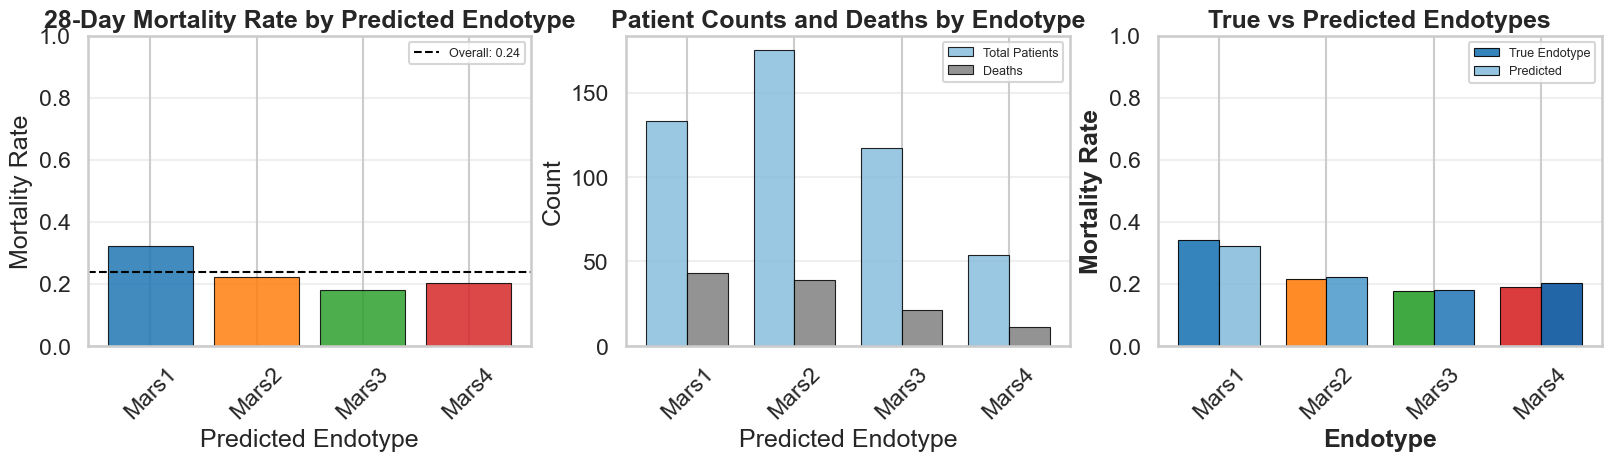


MORTALITY COMPARISON: TRUE vs PREDICTED ENDOTYPES
                 True  Predicted
true_endotype                   
Mars1          0.3409     0.3233
Mars2          0.2159     0.2229
Mars3          0.1780     0.1795
Mars4          0.1887     0.2037


In [ ]:
fig, axes, comparison_df = plot_mortality_stratification(
    stratification_df=stratification_df,
    mort_by_pred=mort_by_pred,
    mars_order=MARS_ORDER,
    mars_palette=MARS_PALETTE,
    title_prefix=""
)

print("\nMORTALITY COMPARISON: TRUE vs PREDICTED ENDOTYPES")
print(comparison_df.round(4))



- Predicted endotypes still separate 28-day mortality: Mars1 has the highest rate (~33%), Mars3 the lowest (~18%), with Mars2/Mars4 in between, confirming the model preserved the clinical risk gradient.
- Sample/context: Counts are uneven (Mars2 most frequent, Mars4 smallest), so mortality rates for Mars4 carry wider uncertainty; overall cohort mortality is ~24%.
- Fidelity check (true vs predicted): Predicted mortality closely matches the original endotype-specific rates (absolute differences < ~1–1.5 pp per class), indicating the supervised model reproduced the mortality ordering seen in the published Mars labels.

### <font color='0077AA'>**3. Discussion**</font>

#### <font color='0088AA'>**Summary of Findings**</font>



#### <font color='0088AA'>**External Generalization Challenges**</font>



#### <font color='0088AA'>**Implications and Future Directions**</font>



---

# <font color='0066CC'>**APPENDIX: External Validation on GSE95233**</font>

The following analysis tests the trained Random Forest model on an independent external cohort. This supplementary section provides full code and results for reproducibility and extended validation; key findings are summarized in the main Discussion.

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE95233

## Testing "best model" on external GSE95233 Dataset

Test the trained Mars classification model on an independent cohort (GSE95233).

The GSE95233 dataset is a whole‑blood microarray study of adult patients with septic shock and healthy controls, originally generated to identify prognostic transcriptional markers of 28‑day mortality. In this project, raw microarray data were downloaded from GEO, probe IDs were mapped to gene symbols, and samples were filtered to retain a single timepoint per patient and exclude those without survival information, yielding a curated cohort with complete outcome labels and clinical characteristics. Expression values from multiple probes mapping to the same gene were averaged, producing a final matrix of 23,520 genes across the filtered samples, which—together with the corresponding metadata—was exported as CSV files for downstream machine‑learning‑based mortality stratification using MARS endotypes.


In [ ]:
# =============================================================================
# Load GSE95233 External Validation Data
# =============================================================================

# Load filtered expression and metadata from GSE95233 processing
gse95233_expr = pd.read_csv(
    "GSE95233_expression_filtered.csv",
    index_col=0
)
gse95233_meta = pd.read_csv(
    "GSE95233_metadata_filtered.csv",
    index_col=0
)

print("GSE95233 expression shape:", gse95233_expr.shape)
print("GSE95233 metadata shape:", gse95233_meta.shape)
print("\nMetadata columns:", list(gse95233_meta.columns))
print("\nSurvival distribution:")
print(gse95233_meta['survival'].value_counts())

GSE95233 expression shape: (23520, 51)
GSE95233 metadata shape: (51, 5)

Metadata columns: ['gender', 'age', 'time point', 'survival', 'source_name']

Survival distribution:
survival
Survivor        34
Non Survivor    17
Name: count, dtype: int64


In [ ]:
# =============================================================================
# Prepare GSE95233 Data for Prediction
# =============================================================================

# Transpose expression matrix to samples × genes (to match training format)
X_gse95233 = gse95233_expr.T.copy()

print("X_gse95233 shape (samples × genes):", X_gse95233.shape)
print("Training data shape was:", X_obj2.shape)

# Find common genes between training and validation
training_genes = set(X_obj2.columns)
validation_genes = set(X_gse95233.columns)
common_genes = training_genes.intersection(validation_genes)

print(f"\nGene overlap:")
print(f"  Training genes: {len(training_genes)}")
print(f"  Validation genes: {len(validation_genes)}")
print(f"  Common genes: {len(common_genes)}")
print(f"  Coverage: {len(common_genes)/len(training_genes)*100:.1f}% of training genes")

# Align validation data to training genes
# For missing genes, fill with 0
X_gse95233_aligned = pd.DataFrame(
    index=X_gse95233.index,
    columns=X_obj2.columns,
    dtype=float
)

# Fill common genes
for gene in common_genes:
    X_gse95233_aligned[gene] = X_gse95233[gene]

# Fill missing genes with 0
X_gse95233_aligned = X_gse95233_aligned.fillna(0)

print("\nAligned validation data shape:", X_gse95233_aligned.shape)
print("Alignment check:", all(X_gse95233_aligned.columns == X_obj2.columns))

X_gse95233 shape (samples × genes): (51, 23520)
Training data shape was: (479, 11222)

Gene overlap:
  Training genes: 11222
  Validation genes: 23520
  Common genes: 9983
  Coverage: 89.0% of training genes

Aligned validation data shape: (51, 11222)
Alignment check: True


In [ ]:
# =============================================================================
# Predict Mars Endotypes on GSE95233
# =============================================================================

# Use the best trained model (tuned Random Forest from hyperparameter tuning)
pred_gse95233 = best_model.predict(X_gse95233_aligned)
proba_gse95233 = best_model.predict_proba(X_gse95233_aligned)

# Extract class labels from the model
class_labels = best_model.named_steps["clf"].classes_

# Create predictions dataframe
pred_gse95233_df = pd.DataFrame(
    proba_gse95233,
    index=X_gse95233_aligned.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_gse95233_df["pred_endotype"] = pred_gse95233

# Add survival information
pred_gse95233_df["survival"] = gse95233_meta["survival"]
pred_gse95233_df["mortality"] = pred_gse95233_df["survival"].map({
    "Survivor": 0,
    "Non Survivor": 1
})

print("Predicted endotype distribution (GSE95233):")
print(pred_gse95233_df["pred_endotype"].value_counts())
print("\nSamples with mortality data:")
print(pred_gse95233_df["mortality"].value_counts(dropna=False))

Predicted endotype distribution (GSE95233):
pred_endotype
Mars4    50
Mars2     1
Name: count, dtype: int64

Samples with mortality data:
mortality
0    34
1    17
Name: count, dtype: int64


In [ ]:
# =============================================================================
# Mortality Stratification on GSE95233
# =============================================================================

# Filter to samples with mortality outcome
gse95233_stratification = pred_gse95233_df.dropna(subset=["mortality"])

mort_by_pred_gse95233 = gse95233_stratification.groupby("pred_endotype")["mortality"].agg(
    ["mean", "sum", "count"]
).round(4)
mort_by_pred_gse95233.columns = ["mortality_rate", "deaths", "total_samples"]

print("\n28-DAY MORTALITY BY PREDICTED ENDOTYPE (GSE95233):")
print(mort_by_pred_gse95233)

# Overall mortality rate
overall_mort_gse95233 = gse95233_stratification["mortality"].mean()
print(f"\nOverall mortality rate (GSE95233): {overall_mort_gse95233:.3f}")


28-DAY MORTALITY BY PREDICTED ENDOTYPE (GSE95233):
               mortality_rate  deaths  total_samples
pred_endotype                                       
Mars2                    1.00       1              1
Mars4                    0.32      16             50

Overall mortality rate (GSE95233): 0.333


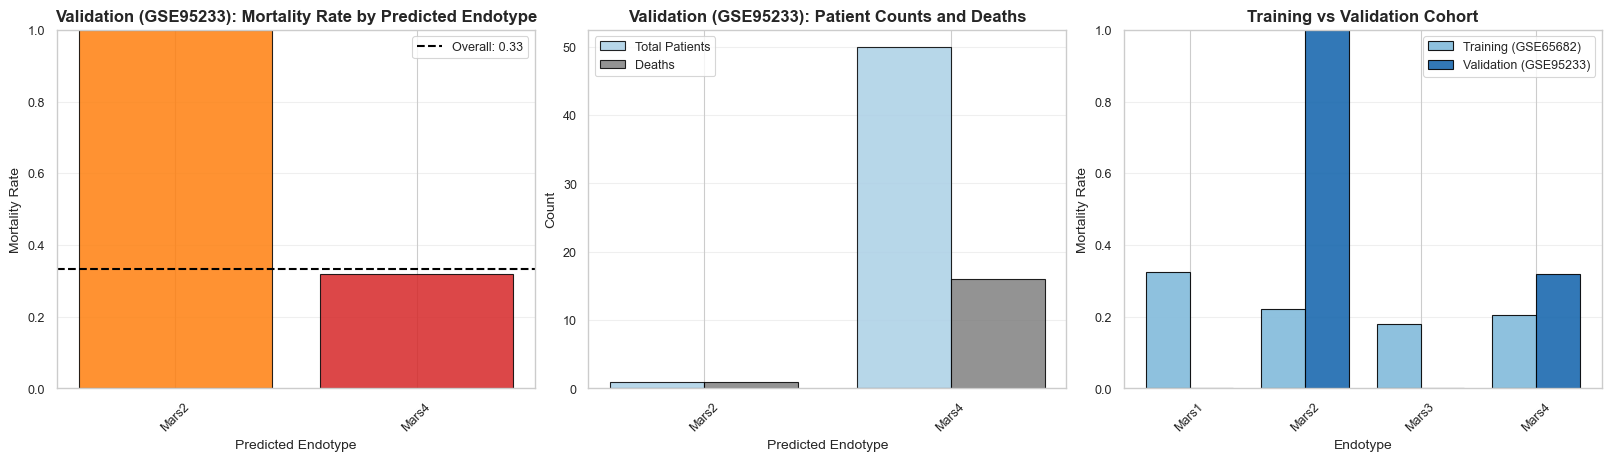


MORTALITY COMPARISON: TRAINING vs VALIDATION COHORTS
Training - Overall mortality: 0.238
Validation - Overall mortality: 0.333

Endotype-specific mortality rates:
               Training (GSE65682)  Validation (GSE95233)
pred_endotype                                            
Mars1                        0.323                   0.00
Mars2                        0.223                   1.00
Mars3                        0.180                   0.00
Mars4                        0.204                   0.32


In [ ]:
overall_mort_training = stratification_df["mortality_28day"].mean()
fig, axes, comparison_cohorts = plot_mortality_stratification_validation(
    mort_by_pred_training=mort_by_pred,
    overall_mort_training=overall_mort_training,
    mort_by_pred_validation=mort_by_pred_gse95233,
    overall_mort_validation=overall_mort_gse95233,
    training_label="Training (GSE65682)",
    validation_label="Validation (GSE95233)",
    mars_order=MARS_ORDER,
    mars_palette=MARS_PALETTE,
    title_prefix=""
)

print("\nMORTALITY COMPARISON: TRAINING vs VALIDATION COHORTS")
print(f"Training - Overall mortality: {overall_mort_training:.3f}")
print(f"Validation - Overall mortality: {overall_mort_gse95233:.3f}")
print("\nEndotype-specific mortality rates:")
print(comparison_cohorts.round(3))

In [ ]:
# =============================================================================
# Statistical Validation Summary
# =============================================================================

print("\n" + "="*70)
print("EXTERNAL VALIDATION SUMMARY")
print("="*70)

print(f"\nTraining Cohort (GSE65682):")
print(f"  Samples with mortality: {len(stratification_df)}")
print(f"  Overall mortality: {overall_mort_training:.3f}")
print(f"  Endotype distribution:")
for endotype in sorted(pred_all_df['pred_endotype'].unique()):
    count = (pred_all_df['pred_endotype'] == endotype).sum()
    print(f"    {endotype}: {count}")

print(f"\nValidation Cohort (GSE95233):")
print(f"  Samples with mortality: {len(gse95233_stratification)}")
print(f"  Overall mortality: {overall_mort_gse95233:.3f}")
print(f"  Endotype distribution:")
for endotype in sorted(pred_gse95233_df['pred_endotype'].unique()):
    count = (pred_gse95233_df['pred_endotype'] == endotype).sum()
    print(f"    {endotype}: {count}")

print(f"\nGene Coverage:")
print(f"  Common genes: {len(common_genes)} / {len(training_genes)} ({len(common_genes)/len(training_genes)*100:.1f}%)")

print("\n" + "="*70)

# Save GSE95233 predictions and results
pred_gse95233_df.to_csv("gse95233_mars_predictions.csv")
mort_by_pred_gse95233.to_csv("gse95233_mortality_by_endotype.csv")
comparison_cohorts.to_csv("mortality_stratification_comparison.csv")

print("\n✓ Saved validation results:")
print("  - gse95233_mars_predictions.csv")
print("  - gse95233_mortality_by_endotype.csv")
print("  - mortality_stratification_comparison.csv")


EXTERNAL VALIDATION SUMMARY

Training Cohort (GSE65682):
  Samples with mortality: 479
  Overall mortality: 0.238
  Endotype distribution:
    Mars1: 133
    Mars2: 175
    Mars3: 117
    Mars4: 54

Validation Cohort (GSE95233):
  Samples with mortality: 51
  Overall mortality: 0.333
  Endotype distribution:
    Mars2: 1
    Mars4: 50

Gene Coverage:
  Common genes: 9983 / 11222 (89.0%)


✓ Saved validation results:
  - gse95233_mars_predictions.csv
  - gse95233_mortality_by_endotype.csv
  - mortality_stratification_comparison.csv
